# [Project 3: Camera Calibration and Fundamental Matrix Estimation with RANSAC](https://www.cc.gatech.edu/~hays/compvision/proj3)


(1) Camera Projection Matrix  
(2) Fundamental Matrix Estimation  
(3) Fundamental Matrix with RANSAC   
(4) Comparison of the results from (2) and (3)   
(5) Using F-Matrix Estimation w/ RANSAC for Visual Odometry   

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from vision.utils import (
    verify,
    evaluate_points,
    visualize_points,
    visualize_points_image,
    plot3dview,
    load_image,
    draw_epipolar_lines,
    get_matches,
    show_correspondence2,
)

## Part 1: Camera Projection Matrix

In [2]:
# Load the data
img_path = "data/CCB_GaTech/pic_a.jpg"
points_2d = np.loadtxt("data/CCB_GaTech/pts2d-norm-pic_a.txt")
points_3d = np.loadtxt("data/CCB_GaTech/pts3d-norm.txt")

# (Optional) Uncomment these four lines once you have your code working with the easier, normalized points above.
# points_2d = np.loadtxt('../data/CCB_GaTech/pts2d-pic_b.txt')
# points_3d = np.loadtxt('../data/CCB_GaTech/pts3d.txt')

### Calculate the projection matrix given corresponding 2D & 3D points

In [3]:
from vision.part1_projection_matrix import (
    calculate_projection_matrix,
    calculate_camera_center,
)

from tests.test_part1 import (
    test_projection,
    test_calculate_projection_matrix,
    test_calculate_camera_center,
)

In [4]:
print("projection():", verify(test_projection))

projection(): "Correct"


The projection matrix is
 [[ 0.76785834 -0.49384797 -0.02339781  0.00674445]
 [-0.0852134  -0.09146818 -0.90652332 -0.08775678]
 [ 0.18265016  0.29882917 -0.07419242  1.        ]]
The total residual is 0.002227


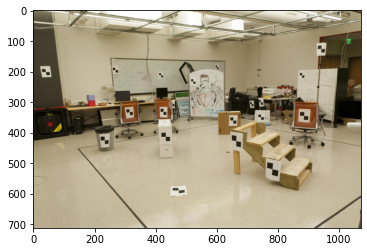

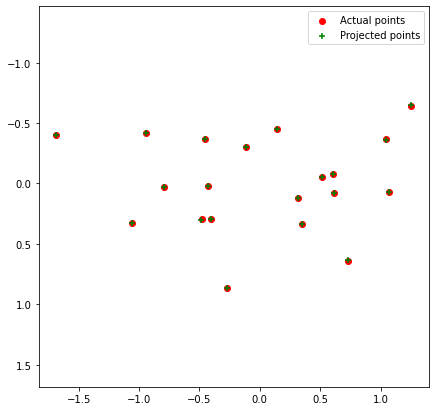

In [5]:
M = calculate_projection_matrix(points_2d, points_3d)
print("The projection matrix is\n", M)

[projected_2d_pts, residual] = evaluate_points(M, points_2d, points_3d)
print("The total residual is {:f}".format(residual))
plt.figure()
plt.imshow(load_image(img_path))
visualize_points(points_2d, projected_2d_pts)

In [6]:
print("calculate_projection_matrix():", verify(test_calculate_projection_matrix))

calculate_projection_matrix(): "Correct"


### Calculate the camera center using M found from the previous step

The estimated location of the camera is <-1.5126, -2.3517, 0.2827>


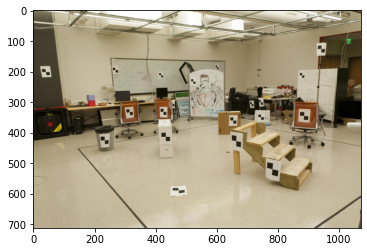

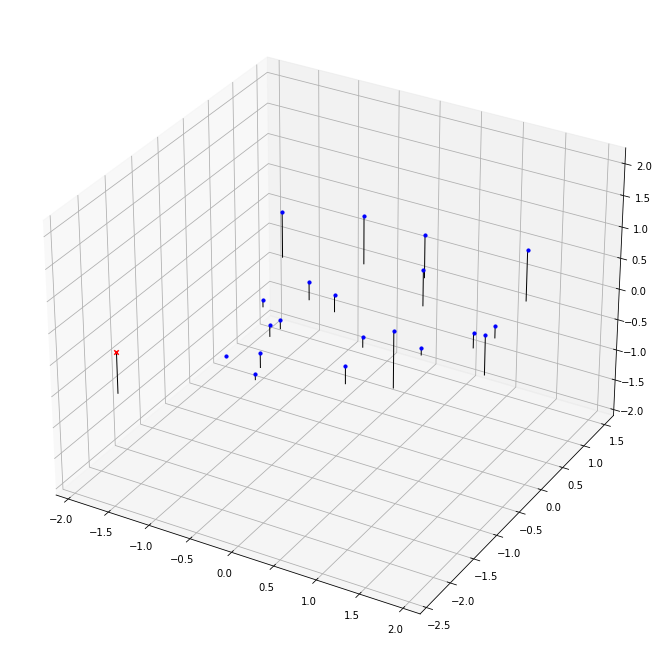

In [7]:
center = calculate_camera_center(M)
print(
    "The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>".format(*center)
)
plt.figure()
plt.imshow(load_image(img_path))
ax = plot3dview(points_3d, center)

In [ ]:
print("test_calculate_camera_center():", verify(test_calculate_camera_center))

## Camera Calibration for Argoverse image data
We'll now estimate the position of a camera mounted on an autonomous vehicle, using data from Argoverse. We'll use images from the "ring front center" camera, which faces forward.


<img src="https://www.argoverse.org/assets/images/reference_images/O2V4_vehicle_annotation.jpg" alt="Drawing" style="width: 400px;"/>


In [8]:
# Argoverse Scene 3
img_path = "data/argoverse_log_d60558d2_pair3/pic3.jpg"
points_2d = np.loadtxt("data/argoverse_log_d60558d2_pair3/points_2d.txt")
points_3d = np.loadtxt("data/argoverse_log_d60558d2_pair3/points_3d.txt")
# # # Argoverse Scene 2
# img_path = '../data/argoverse_log_d60558d2_pair2/pic2.jpg'
# points_2d = np.loadtxt('../data/argoverse_log_d60558d2_pair2/points_2d.txt')
# points_3d = np.loadtxt('../data/argoverse_log_d60558d2_pair2/points_3d.txt')

The projection matrix is
 [[-5.69544250e+02  8.49628922e+02  8.30195161e+00  9.44253377e+02]
 [-3.57429566e+02  2.96164295e+00  8.46650823e+02 -6.04042207e+02]
 [-6.04034739e-01  7.57864789e-03  7.05858919e-03  1.00000000e+00]]
The total residual is 0.000000


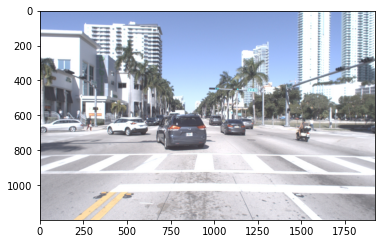

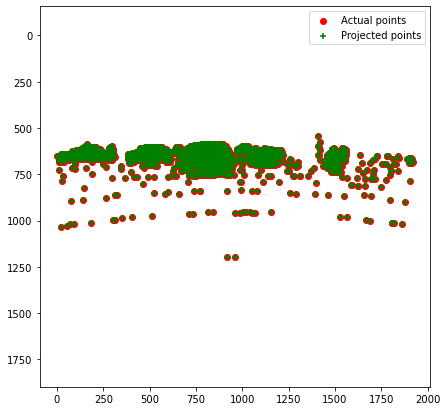

In [9]:
M = calculate_projection_matrix(points_2d, points_3d)
print("The projection matrix is\n", M)

[projected_2d_pts, residual] = evaluate_points(M, points_2d, points_3d)
print("The total residual is {:f}".format(residual))
plt.figure()
plt.imshow(load_image(img_path))
visualize_points(points_2d, projected_2d_pts)

For these 2d-3d pairs, the "world" frame is defined as the "ego-vehicle" frame, where the origin is at the center of the back axle of the vehicle.

Thus, if your camera center estimate is correct, it should tell you how far to move forward (+x) and how far to move left (+y) and move up (+z) to reach teh camera's position.


The "egovehicle" coordinate system and "camera" coordinate system:
<img width="300"  src="https://user-images.githubusercontent.com/16724970/108759169-034e6180-751a-11eb-8a06-fbe344f1ee68.png">
<img width="300" src="https://user-images.githubusercontent.com/16724970/108759182-06495200-751a-11eb-8162-8b17f9cdee4b.png">

The estimated location of the camera is <1.6721, -0.0044, 1.4194>


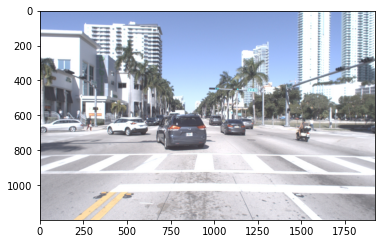

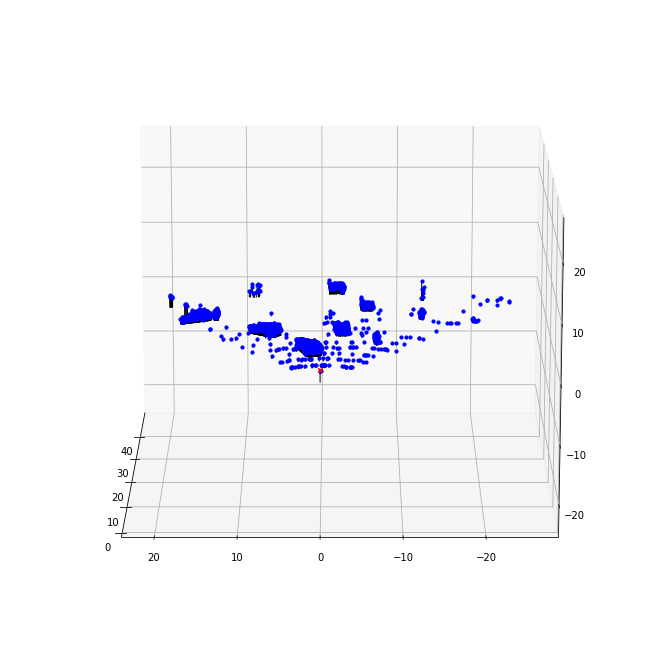

In [10]:
center = calculate_camera_center(M)
print(
    "The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>".format(*center)
)
plt.figure()
plt.imshow(load_image(img_path))
ax = plot3dview(points_3d, center)
ax.view_init(elev=15, azim=180)

## Part 2: Fundamental Matrix Estimation
We'll now solve for the Fundamental Matrix by implementing [Hartley's 8-Point algorithm](https://www.cse.unr.edu/~bebis/CS485/Handouts/hartley.pdf).

In [14]:
from vision.part2_fundamental_matrix import estimate_fundamental_matrix

In [15]:
# Load the data
points_2d_pic_a = np.loadtxt("data/CCB_GaTech/pts2d-pic_a.txt")
points_2d_pic_b = np.loadtxt("data/CCB_GaTech/pts2d-pic_b.txt")
img_a = load_image("data/CCB_GaTech/pic_a.jpg")
img_b = load_image("data/CCB_GaTech/pic_b.jpg")

### Estimate fundamental matrix

In [16]:
from tests.test_part2 import (
    test_estimate_fundamental_matrix,
    test_normalize_points,
    test_unnormalize_F,
)

print("test_estimate_fundamental_matrix():", verify(test_estimate_fundamental_matrix))
print("test_normalize_points():", verify(test_normalize_points))
print("test_unnormalize_F():", verify(test_unnormalize_F))

test_estimate_fundamental_matrix(): "Correct"
test_normalize_points(): "Correct"
test_unnormalize_F(): "Correct"


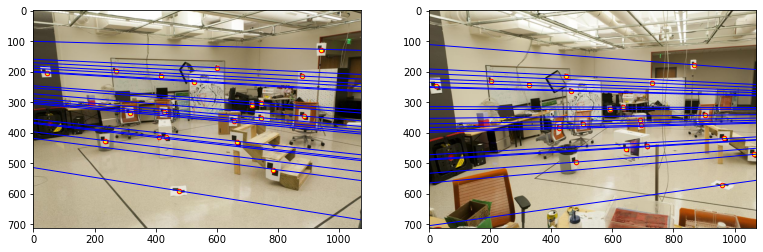

In [17]:
F = estimate_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(F, img_a, img_b, points_2d_pic_a, points_2d_pic_b, figsize=(13, 4))

## Part 3: Fundamental Matrix with RANSAC (Szeliski 6.1.4)

**Mount Rushmore**: This pair is easy, and most of the initial matches are correct. The base fundamental matrix estimation without coordinate normalization will work fine with RANSAC. 

**Notre Dame**: This pair is difficult because the keypoints are largely on the same plane. Still, even an inaccurate fundamental matrix can do a pretty good job of filtering spurious matches.  

**Gaudi**: This pair is difficult and doesn't find many correct matches unless you run at high resolution, but that will lead to tens of thousands of SIFT features, which will be somewhat slow to process. Normalizing the coordinates seems to make this pair work much better.  

**Woodruff**: This pair has a clearer relationship between the cameras (they are converging and have a wide baseline between them). The estimated fundamental matrix is less ambiguous and you should get epipolar lines qualitatively similar to part 2 of the project.

In [18]:
from vision.part3_ransac import (
    calculate_num_ransac_iterations,
    ransac_fundamental_matrix,
)

In [20]:
# Load the data
# Mount Rushmore
# pic_a = load_image('../data/Mount_Rushmore/9193029855_2c85a50e91_o.jpg'); scale_a = 0.25
# pic_b = load_image('../data/Mount_Rushmore/7433804322_06c5620f13_o.jpg'); scale_b = 0.37
# n_feat = 5e4

# Notre Dame
pic_a = load_image("data/Notre_Dame/921919841_a30df938f2_o.jpg")
scale_a = 0.5
pic_b = load_image("data/Notre_Dame/4191453057_c86028ce1f_o.jpg")
scale_b = 0.5
n_feat = 4e3

# Gaudi
# pic_a = load_image('../data/Episcopal_Gaudi/3743214471_1b5bbfda98_o.jpg'); scale_a = 0.8
# pic_b = load_image('../data/Episcopal_Gaudi/4386465943_8cf9776378_o.jpg'); scale_b = 1.0
# n_feat = 2e4

# Woodruff
# pic_a = load_image('../data/Woodruff_Dorm/wood1.jpg'); scale_a = 0.65
# pic_b = load_image('../data/Woodruff_Dorm/wood2.jpg'); scale_b = 0.65
# n_feat = 5e4

pic_a = cv2.resize(pic_a, None, fx=scale_a, fy=scale_a)
pic_b = cv2.resize(pic_b, None, fx=scale_b, fy=scale_b)

Found 1269 possibly matching features


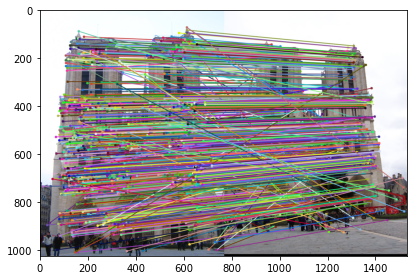

In [21]:
# Finds matching points in the two images using OpenCV's implementation of SIFT.
# There can still be many spurious matches, though.
points_2d_pic_a, points_2d_pic_b = get_matches(pic_a, pic_b, n_feat)
print("Found {:d} possibly matching features".format(len(points_2d_pic_a)))
match_image = show_correspondence2(
    pic_a,
    pic_b,
    points_2d_pic_a[:, 0],
    points_2d_pic_a[:, 1],
    points_2d_pic_b[:, 0],
    points_2d_pic_b[:, 1],
)
plt.figure()
plt.imshow(match_image)
plt.tight_layout()

### Calculate the Fundamental Matrix using RANSAC
Compare your results on the Notre Dame image pair below to your results from Project 2. How accurate do the point correspondences look now? 

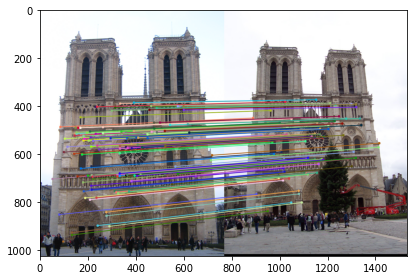

In [22]:
F, matched_points_a, matched_points_b = ransac_fundamental_matrix(
    points_2d_pic_a, points_2d_pic_b
)

# Draw the epipolar lines on the images and corresponding matches
match_image = show_correspondence2(
    pic_a,
    pic_b,
    matched_points_a[:, 0],
    matched_points_a[:, 1],
    matched_points_b[:, 0],
    matched_points_b[:, 1],
)
plt.figure()
plt.imshow(match_image)
plt.tight_layout()

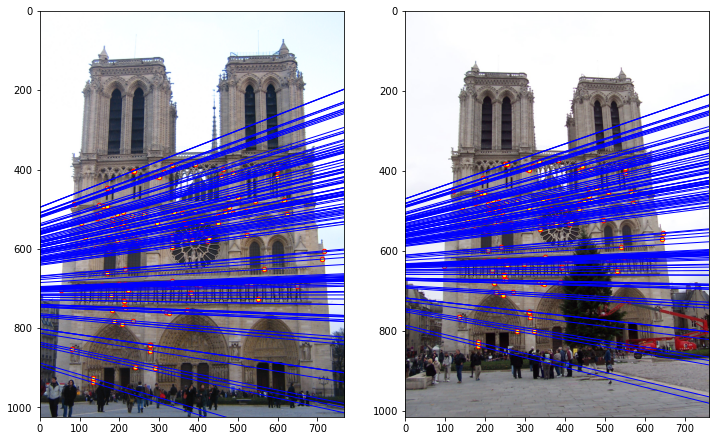

In [23]:
draw_epipolar_lines(
    F, pic_a, pic_b, matched_points_a, matched_points_b, figsize=(12, 8)
)

In [24]:
from tests.test_part3 import (
    test_calculate_num_ransac_iterations,
    test_ransac_fundamental_matrix,
)

print(
    "test_calculate_num_ransac_iterations():",
    verify(test_calculate_num_ransac_iterations),
)
print("test_ransac_fundamental_matrix():", verify(test_ransac_fundamental_matrix))

test_calculate_num_ransac_iterations(): "Correct"
test_ransac_fundamental_matrix(): "Correct"


## Part 4: Performance Comparison
We'll now test the quality of Fundamental matrices we can compute with and without RANSAC on an image pair from the [Argoverse](https://www.argoverse.org/) autonomous driving dataset. Does RANSAC improve the results?

In [25]:
from vision.part3_ransac import (
    calculate_num_ransac_iterations,
    ransac_fundamental_matrix,
)

In [26]:
pic_a = load_image(
    "data/argoverse_log_273c1883/ring_front_center_315975640448534784.jpg"
)
scale_a = 0.5
pic_b = load_image(
    "data/argoverse_log_273c1883/ring_front_center_315975643412234000.jpg"
)
scale_b = 0.5

n_feat = 4e3
num_matches_to_plot = 50

pic_a = cv2.resize(pic_a, None, fx=scale_a, fy=scale_a)
pic_b = cv2.resize(pic_b, None, fx=scale_b, fy=scale_b)

Found 266 possibly matching features


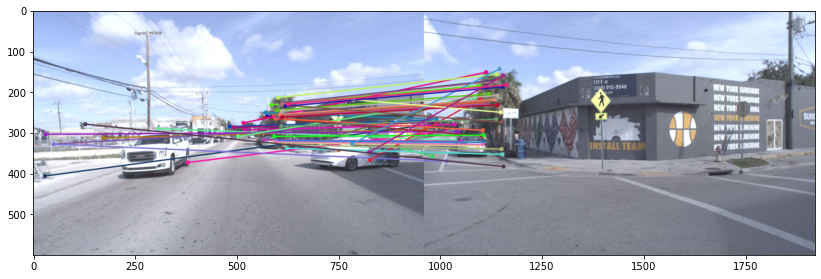

In [27]:
points_2d_pic_a, points_2d_pic_b = get_matches(pic_a, pic_b, n_feat)

print("Found {:d} possibly matching features".format(len(points_2d_pic_a)))
match_image = show_correspondence2(
    pic_a,
    pic_b,
    points_2d_pic_a[:num_matches_to_plot, 0],
    points_2d_pic_a[:num_matches_to_plot, 1],
    points_2d_pic_b[:num_matches_to_plot, 0],
    points_2d_pic_b[:num_matches_to_plot, 1],
)
plt.figure(figsize=(14, 6))
plt.imshow(match_image)

### Without RANSAC Estimation
If we ignore RANSAC and use only our implementation from Part2, we get the following results:

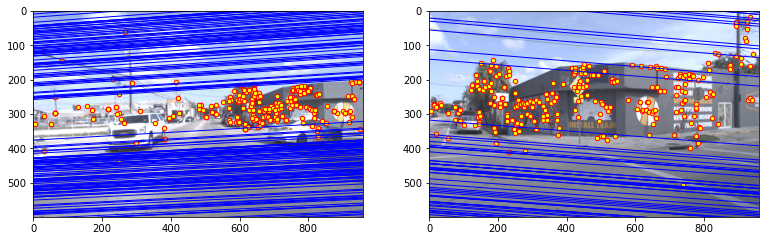

In [28]:
F_wo_ransac = estimate_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(
    F_wo_ransac, pic_a, pic_b, points_2d_pic_a, points_2d_pic_b, figsize=(13, 4)
)

### With Ransac Estimation
Now we'll use our RANSAC implementation from Part 3. Where does the epipole fall in the left image? (think about what it represents). The camera is mounted on an autonomous vehicle identical to the vehicle seen up ahead in the left image.

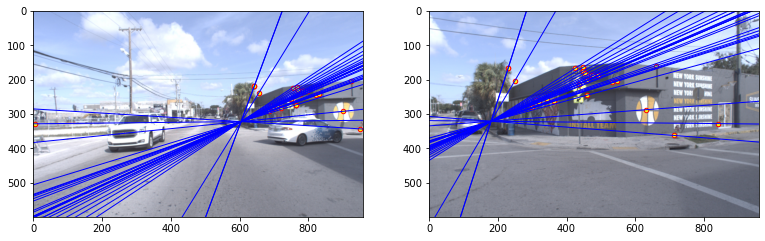

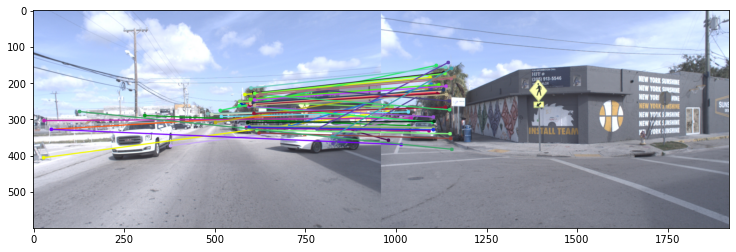

In [29]:
F, matched_points_a, matched_points_b = ransac_fundamental_matrix(
    points_2d_pic_a, points_2d_pic_b
)

draw_epipolar_lines(
    F, pic_a, pic_b, matched_points_a, matched_points_b, figsize=(13, 4)
)

match_image = show_correspondence2(
    pic_a,
    pic_b,
    points_2d_pic_a[:num_matches_to_plot, 0],
    points_2d_pic_a[:num_matches_to_plot, 1],
    points_2d_pic_b[:num_matches_to_plot, 0],
    points_2d_pic_b[:num_matches_to_plot, 1],
)
plt.figure(figsize=(14, 4))
plt.imshow(match_image)

## Part 5: Visual Odometry

In [1]:
from vision.vo import get_visual_odometry, plot_poses

For the following gif, we try to obtain the visual odometry of a camera mounted on a robot from the individual image frames.

![VO](https://user-images.githubusercontent.com/16724970/100487935-34fd8b00-30d9-11eb-9941-7735fcae445c.gif "VO")

In [2]:
# This may take a few minutes to run across 20 image frames from the Argoverse dataset
poses_wTi = get_visual_odometry()

Rotation about y-axis from frame 0 -> 1: 0.28 degrees
Rotation about y-axis from frame 1 -> 2: 0.41 degrees
Rotation about y-axis from frame 2 -> 3: 0.56 degrees
Rotation about y-axis from frame 3 -> 4: 0.90 degrees
Rotation about y-axis from frame 4 -> 5: 1.50 degrees
Rotation about y-axis from frame 5 -> 6: 2.20 degrees
Rotation about y-axis from frame 6 -> 7: 3.55 degrees
Rotation about y-axis from frame 7 -> 8: 5.91 degrees
Rotation about y-axis from frame 8 -> 9: 7.60 degrees
Rotation about y-axis from frame 9 -> 10: 8.92 degrees
Rotation about y-axis from frame 10 -> 11: 10.04 degrees
Rotation about y-axis from frame 11 -> 12: 10.99 degrees
Rotation about y-axis from frame 12 -> 13: 11.32 degrees
Rotation about y-axis from frame 13 -> 14: 10.65 degrees
Rotation about y-axis from frame 14 -> 15: 8.93 degrees
Rotation about y-axis from frame 15 -> 16: 6.36 degrees
Rotation about y-axis from frame 16 -> 17: 3.23 degrees
Rotation about y-axis from frame 17 -> 18: 0.95 degrees
Rotatio

C:\Users\hanhf\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


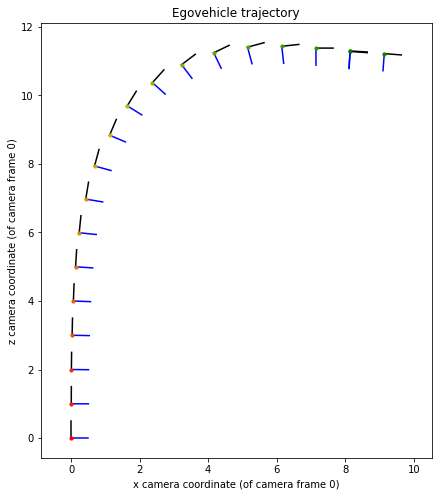

In [3]:
plot_poses(poses_wTi)